In [3]:
from tsai.basics import *
import json
import numpy as np
import fastai
import fastai.tabular
from fastai.vision.all import *
from CNN import *
from tsai.data.metadatasets import TSMetaDataset, TSMetaDatasets

In [7]:
with open("data_config.json", "r") as outfile:
    data = json.load(outfile, strict=False)
extent = list(data['extent'])
data_numpy = np.load('data.npy')

d, n_epochs, window_size, batch_size = 64, 35, 60, 16
model = AutoEncoder(d)
load_model(f'model/d_{d}_epoch_{n_epochs}', model, None)

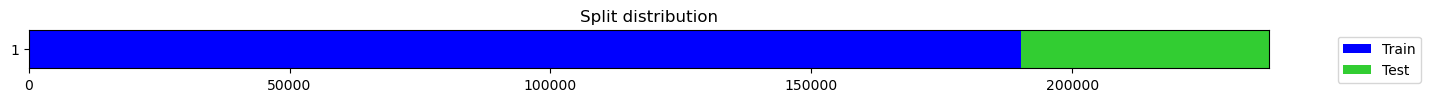

In [8]:
dsets = []
for i in range(data_numpy.shape[0]):
    encoded = model.encrypt(torch.tensor(data_numpy[i], dtype=torch.float32).unsqueeze(0).transpose(0, 1))
    X, y = SlidingWindow(window_size, horizon=1)(encoded.detach().numpy())
    tfms = [None, TSForecasting()]
    dset = TSDatasets(X, y, tfms=tfms)
    dsets.append(dset)
    
metadataset = TSMetaDataset(dsets)
splits = TimeSplitter(show_plot=True)(metadataset)
metadatasets = TSMetaDatasets(metadataset, splits=splits)
dls = TSDataLoaders.from_dsets(metadatasets.train, metadatasets.valid)

In [9]:
model_name = "TSTPlus"
learn = ts_learner(dls, arch="TSTPlus")

In [10]:
epochs = 10
learn.fit_one_cycle(epochs)

epoch,train_loss,valid_loss,time
0,81.146675,61.647655,01:04
1,64.235542,34.118629,01:04
2,54.673000,35.748188,01:03
3,32.852272,28.490414,01:04
4,23.266394,92.153023,01:03
5,16.115940,19.505255,01:04
6,12.475174,11.711739,01:04
7,10.189807,9.721374,01:04
8,7.243547,7.290554,01:05
9,6.876093,7.254975,01:04


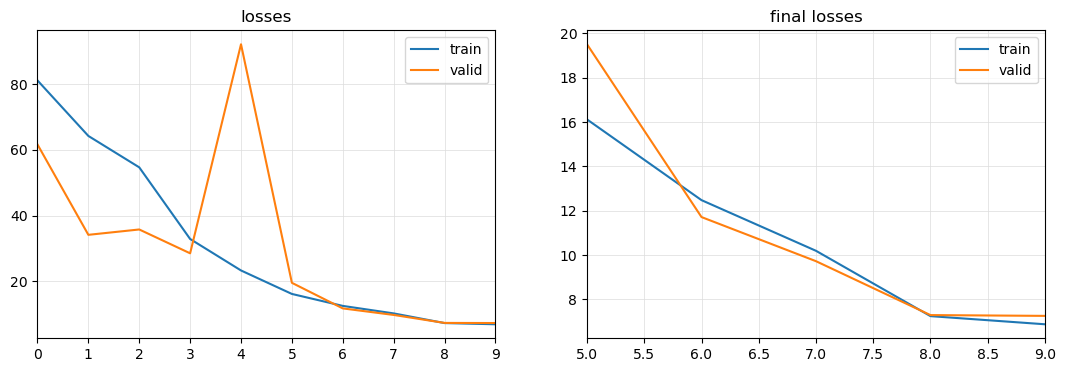

In [15]:
learn.recorder.plot_metrics()

In [17]:
learn.export(f'time_model/d_{d}_epoch_{epochs}_{model_name}.pkl')